In [1]:
import sys
import os
import time
import glob
import pandas as pd
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [2]:
print('python version', sys.version_info)
print('tf version', tf.__version__, 'keras version', keras.__version__)

python version sys.version_info(major=3, minor=8, micro=5, releaselevel='final', serial=0)
tf version 2.2.0 keras version 2.3.0-tf


In [3]:
current_time_millis = lambda: int(round(time.time() * 1000))


# Datasource folders


In [4]:
YAHOO_DS="../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0"
DIRS = ['A1Benchmark', 'A2Benchmark','A3Benchmark', 'A4Benchmark']
DATA_FILE_EXTENSION = "*.csv"
Benchmark_dir  = YAHOO_DS + os.path.sep + DIRS[1] + os.path.sep 
Benchmark_dir

'../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/'

# Read data 

In [5]:
def read_data_set(file_name_to_read):
    dataset = pd.read_csv(file_name_to_read, usecols=[1])
    dataset = dataset.values
    dataset = dataset.astype('float32')    
    return dataset

In [6]:
def read_data(file, timeVariantColumns):
    df = pd.read_csv(file)
    return df[timeVariantColumns].values.astype('float64'), df.values.astype('float64')

In [7]:
Benchmark_dir  = YAHOO_DS + os.path.sep + DIRS[1] + os.path.sep 
benchmark_files = glob.glob(Benchmark_dir + DATA_FILE_EXTENSION, recursive=True)

timeVariantColumns = ['value']
for file_name in benchmark_files[:1]:    
    tsData, data = read_data(file_name, ['value'])
    print("Shapes of data read from file: time variant data {}, full data {}".format(tsData.shape, data.shape))

Shapes of data read from file: time variant data (1421, 1), full data (1421, 3)


# Prepare look back window based data set

In [8]:
def look_back_and_create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(look_back, len(dataset)):
        a = dataset[i-look_back:i, 0]
        dataX.append(a)
        dataY.append(dataset[i])
    return np.array(dataX), np.array(dataY)

Files in A1|2|3|4 benchmark folder

Test look back data preparation

In [9]:
Benchmark_dir  = YAHOO_DS + os.path.sep + DIRS[1] + os.path.sep 
benchmark_files = glob.glob(Benchmark_dir + DATA_FILE_EXTENSION, recursive=True)

print("{:d} .csv files in {:s}".format(len(benchmark_files), Benchmark_dir))
look_back=5
# do across all files in the benchmark. for now just the first one in glob list
for file_name in benchmark_files[:1]:
    print("Preparing file", file_name)
    tsData, data = read_data(file_name, ['value'])
    print("Shapes of data read from file: time variant data {}, full data {}".format(tsData.shape, data.shape))
    # look back and create reshaped dataset
    reshapedX, reshapedY = look_back_and_create_dataset(tsData, look_back)
    print("Look back reshapedX.shape", reshapedX.shape, "reshapedY.shape", reshapedY.shape)    
    reshapedXY = np.hstack((reshapedX, reshapedY))      
    print("ReshapedXY \n", reshapedXY[:10])

100 .csv files in ../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/
Preparing file ../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/synthetic_10.csv
Shapes of data read from file: time variant data (1421, 1), full data (1421, 3)
Look back reshapedX.shape (1416, 5) reshapedY.shape (1416, 1)
ReshapedXY 
 [[127.69923816  23.06961419 246.1188566  295.93781848 264.6499858
  122.23286746]
 [ 23.06961419 246.1188566  295.93781848 264.6499858  122.23286746
  238.54006612]
 [246.1188566  295.93781848 264.6499858  122.23286746 238.54006612
  356.59069416]
 [295.93781848 264.6499858  122.23286746 238.54006612 356.59069416
  439.19625187]
 [264.6499858  122.23286746 238.54006612 356.59069416 439.19625187
  735.37467526]
 [122.23286746 238.54006612 356.59069416 439.19625187 735.37467526
  621.57485665]
 [238.54006612 356.59069416 439.19625187 735.37467526 621.57485665
  514.83835704]
 [356.59069416 439.1962518

# Prepare train and test splits

In [10]:
def split_data_set(dataset, split=0.67):
    train_size = int(len(dataset) * split)
    train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
    return train, test

In [11]:
def get_train_test_data_from_file(file_name, timeVariantColumns, split=.8, look_back=1):    
    tsData, data = read_data(file_name, timeVariantColumns)    
    reshapedX, reshapedY = look_back_and_create_dataset(tsData, look_back)         
    Xtrain, Xtest = split_data_set(reshapedX, split)
    Ytrain, Ytest = split_data_set(reshapedY, split) 
    return data, reshapedX, reshapedY, Xtrain, Ytrain, Xtest, Ytest  

Test training, test split

In [12]:
# do across all files in the benchmark. for now just the first one in glob list
Benchmark_dir  = YAHOO_DS + os.path.sep + DIRS[1] + os.path.sep 
benchmark_files = glob.glob(Benchmark_dir + DATA_FILE_EXTENSION, recursive=True)
timeVariantColumns = ['value']
split = 0.8
look_back = 24
for data_file in benchmark_files[:1]:
    print('File Name : ', data_file)
    data, reshapedX, reshapedY, Xtrain, Ytrain, Xtest, Ytest = get_train_test_data_from_file(data_file, timeVariantColumns, split, look_back)    
    print("Shapes: Original data {}, reshapedX {}, reshapedY {}".format(data.shape, reshapedX.shape, reshapedY.shape))
    print("Shapes: Xtrain {}, Ytrain {}, Xtest {}, Ytest {}".format(Xtrain.shape, Ytrain.shape, Xtest.shape, Ytest.shape))
    
#     print("Xtrain ... first 5\n {} \n Ytrain ... first 5 \n {}".format(Xtrain[:5], Ytrain[:5]))
#     print("Xtest ... first 5\n {} \n Ytest ... first 5 \n {}".format(Xtest[:5], Ytest[:5]))
    

File Name :  ../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/synthetic_10.csv
Shapes: Original data (1421, 3), reshapedX (1397, 24), reshapedY (1397, 1)
Shapes: Xtrain (1117, 24), Ytrain (1117, 1), Xtest (280, 24), Ytest (280, 1)


# Train model

In [13]:
def scale(train, test):
    scaler = MinMaxScaler(feature_range=(0,1))
#     scaler = StandardScaler()
    # fit normalization scaler to train only, but transform both train and test using the scaler fit to train
    scaler.fit(train)
    return scaler, scaler.transform(train), scaler.transform(test)

In [14]:
def train(X, Y, verbose = False ):
    model = Sequential()
    model.add(Dense(8, input_shape=X.shape[1:], activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    start_millis = current_time_millis()
    model.fit(X, Y, epochs=25, batch_size=1000, verbose=verbose)
    end_millis = current_time_millis()
    print ("Time taken to train the model is {} ms".format(end_millis - start_millis))
    return model

In [15]:
def predict(model, X):
    return model.predict(X)

In [16]:
def evaluate_model(model, X, Y):
    score = model.evaluate(X, Y, verbose=0)
    return score, sqrt(score)

In [17]:
def plot_actuals_vs_predictions(Y, YtrainPredicted, YtestPredicted, look_back):
    trainPredictPlot = np.empty_like(Y)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[:len(YtrainPredicted), :] = YtrainPredicted
    
    testPredictPlot = np.empty_like(Y)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(YtrainPredicted):len(Y), :] = YtestPredicted    

    #Now Plot
    plt.figure(figsize=(40,10))
    plt.plot(testPredictPlot, label ='Test Prediction')
    plt.plot(trainPredictPlot, label ='Train Prediction')
    plt.plot(Y, label = 'Actual')
    plt.legend(("Test Prediction", "Train Prediction", "Actual"), loc=3)
    plt.show()

In [ ]:
def get_deviations(actual, predicted):
    return np.aboslute(actual - predicted)

File Name :  ../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/synthetic_10.csv
Shapes: Xtrain (1117, 24), Ytrain (1117, 1), Xtest (280, 24), Ytest (280, 1)
Time taken to train the model is 513 ms
Train Score: 0.00287 MSE 0.05357 RMSE
Test Score: 0.00196 MSE 0.04423 RMSE


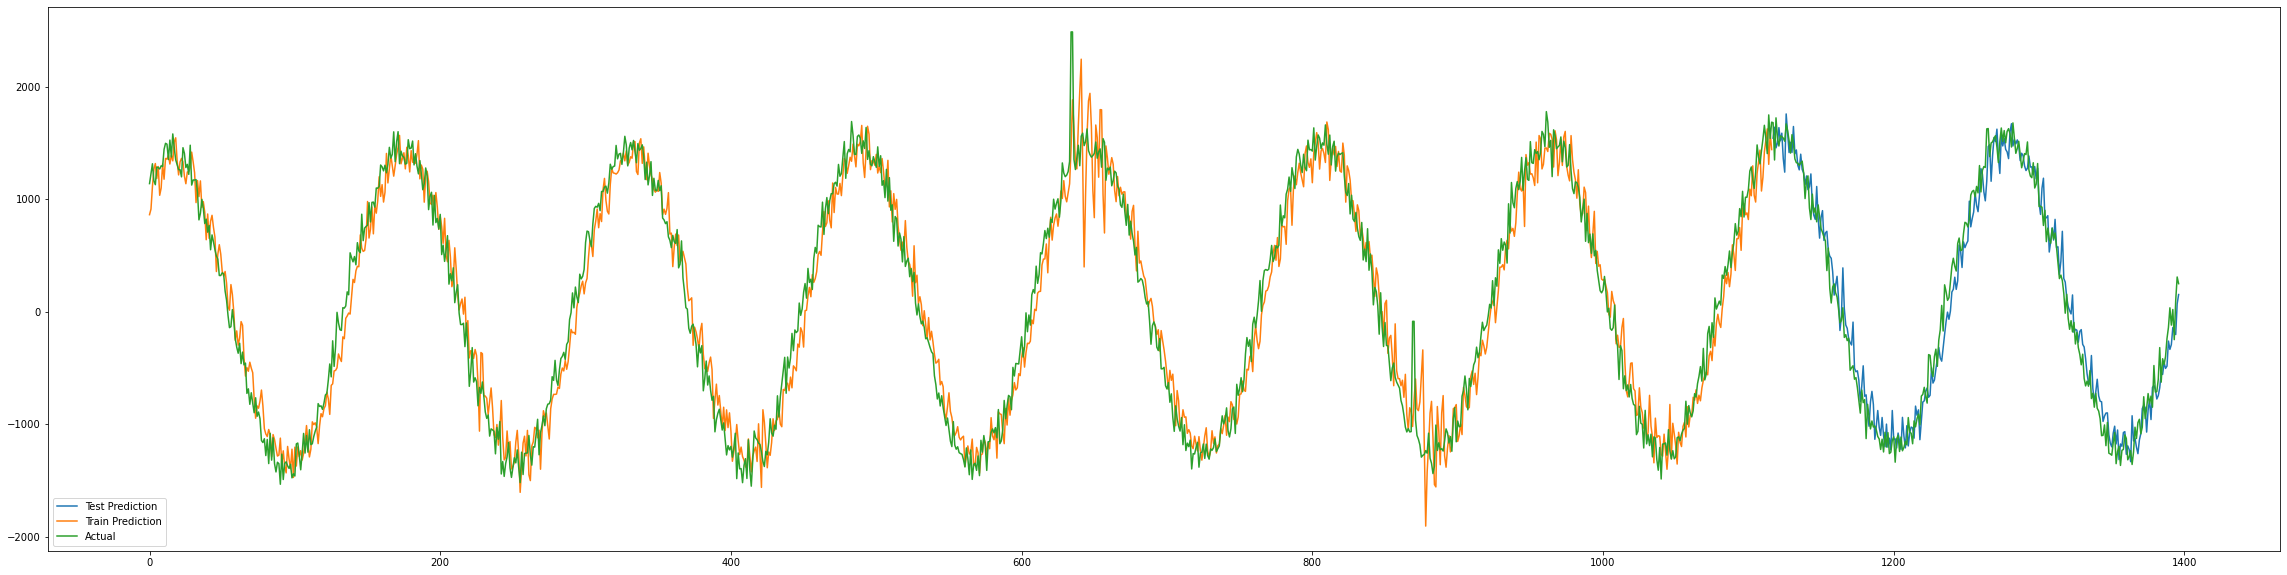

Actual is_anomaly labels in data (array([0, 1]), array([1393,    4]))
[[0.06839596]
 [0.07792335]
 [0.05018486]
 ...
 [0.07530703]
 [0.05902395]
 [0.02396897]]
Min deviation [4.79781107e-07], Max deviation [0.26707039]
Time taken to process all files: 1799 ms


In [35]:
# do across all files in the benchmark. for now just the first one in glob list
Benchmark_dir  = YAHOO_DS + os.path.sep + DIRS[1] + os.path.sep 
benchmark_files = glob.glob(Benchmark_dir + DATA_FILE_EXTENSION, recursive=True)
timeVariantColumns = ['value']
split = 0.8
look_back = 24
start_millis = current_time_millis()
for data_file in benchmark_files[:1]:
    print('File Name : ', data_file)
    data, reshapedX, reshapedY, Xtrain, Ytrain, Xtest, Ytest = get_train_test_data_from_file(data_file, timeVariantColumns, split, look_back)
    print("Shapes: Xtrain {}, Ytrain {}, Xtest {}, Ytest {}".format(Xtrain.shape, Ytrain.shape, Xtest.shape, Ytest.shape))
    scalerX, scaledXtrain, scaledXtest = scale(Xtrain, Xtest)
    scalerY, scaledYtrain, scaledYtest = scale(Ytrain, Ytest)
    
    model = train(X = scaledXtrain, Y = scaledYtrain, verbose = False)
    
    trainMSE, trainRMSE = evaluate_model(model = model, X = scaledXtrain, Y = scaledYtrain)
    print("Train Score: {0:.5f} MSE {1:.5f} RMSE".format(trainMSE, trainRMSE))
    testMSE, testRMSE = evaluate_model(model = model, X = scaledXtest, Y= scaledYtest)
    print("Test Score: {0:.5f} MSE {1:.5f} RMSE".format(testMSE, testRMSE))
    
    YtrainPredicted = predict(model = model, X = scaledXtrain)
    YtestPredicted = predict(model = model, X = scaledXtest)
    
#     print("scaledYtrain ... first 5\n {} \n YtrainPredicted .. first 5 \n {}".format(scaledYtrain[:5], YtrainPredicted[:5]))
#     print("scaledYtest ... first 5\n {} \n YtestPredicted .. first 5 \n {}".format(scaledYtest[:5], YtestPredicted[:5]))
    
    plot_actuals_vs_predictions(reshapedY, scalerY.inverse_transform(YtrainPredicted), scalerY.inverse_transform(YtestPredicted), look_back)
    
    # actual is_anomaly labels
    actualLabels = (data[look_back:, 2] != 0.0).astype('int')    
    print("Actual is_anomaly labels in data", np.unique(actualLabels, return_counts = True))
    
    # calculate deviations for whole dataset
    scaledY = np.vstack((scaledYtrain, scaledYtest))
    scaledX = np.vstack((scaledXtrain, scaledXtest))
    YPredicted = predict(model = model, X = scaledX)
    deviations = np.absolute(scaledY - YPredicted)    
    print(deviations)
    print("Min deviation {}, Max deviation {}".format(np.amin(deviations, axis=0), np.amax(deviations, axis=0)))
    
    # now calculate records with deviations > threshold
    
    
    
end_millis = current_time_millis()    
print ("Time taken to process all files: {} ms".format(end_millis - start_millis))